In [2]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from dictionary import AutoEncoder

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from typing import List, Tuple

/Users/ryansherby/opt/anaconda3/envs/pyML/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
one_gram_samples_df = pd.read_csv('data/1gram_samples.csv', delimiter=",", encoding="utf-8", quotechar='"')

one_gram_samples = one_gram_samples_df['gram'].tolist()

one_gram_targets_df = pd.read_csv('data/1gram_targets.csv', delimiter=",", encoding="utf-8", quotechar='"')

one_gram_targets = one_gram_targets_df['gram'].tolist()

two_grams_df = pd.read_csv('data/2grams.csv', delimiter=",", encoding="utf-8", quotechar='"')

two_grams = two_grams_df['gram'].tolist()

In [4]:
# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m-deduped")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m-deduped")
tokenizer.pad_token = tokenizer.eos_token


The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


In [5]:
# Load Dictionary Learning AutoEncoder
ae = AutoEncoder.from_pretrained(
    "dictionaries/pythia-70m-deduped/mlp_out_layer3/10_32768/ae.pt", 
    map_location=torch.device('cpu')
)

/Users/ryansherby/Library/CloudStorage/OneDrive-Personal/Documents/Columbia/CRIS Lab Project/dictionary_learning/dictionary.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

In [6]:
activation_list = []

def hook_fn(module, input, output):
    activation_list.append(output)


layer_to_hook = model.gpt_neox.layers[3].mlp
hook = layer_to_hook.register_forward_hook(hook_fn)

In [7]:
input = tokenizer('sunset', return_tensors="pt", padding=True, truncation=True)
decoded_tokens = tokenizer.convert_ids_to_tokens(input['input_ids'][0])
output = model(**input)
t = activation_list[0][0].detach().numpy()
activation_list.clear()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [8]:

one_gram_samples_activations = []
one_gram_targets_activations = []
two_gram_activations = []

for one_gram in one_gram_samples[:500]: # TODO: Remove to slicer
    input = tokenizer(one_gram, return_tensors="pt", padding=True, truncation=True)
    decoded_tokens = tokenizer.convert_ids_to_tokens(input['input_ids'][0])
    output = model(**input)
    one_gram_samples_activations.append((activation_list[0][0].detach().numpy()[-1],decoded_tokens[-1])) # Take only last vector
    activation_list.clear()


for one_gram in one_gram_targets[:500]: # TODO: Remove to slicer
    input = tokenizer(one_gram, return_tensors="pt", padding=True, truncation=True)
    decoded_tokens = tokenizer.convert_ids_to_tokens(input['input_ids'][0])
    output = model(**input)
    one_gram_targets_activations.append((activation_list[0][0].detach().numpy()[-1],decoded_tokens[-1])) # Take only last vector
    activation_list.clear()


for two_gram in two_grams[:500]: # TODO: Remove to slicer
    input = tokenizer(two_gram, return_tensors="pt", padding=True, truncation=True)
    decoded_tokens = tokenizer.convert_ids_to_tokens(input['input_ids'][0]) 
    output = model(**input)
    two_gram_activations.append((activation_list[0][0].detach().numpy()[-1],decoded_tokens[-1])) # Take only last vector
    activation_list.clear()

In [9]:
# Convert activations to sparse representations
one_gram_samples_sparse = []
one_gram_targets_sparse = []
two_gram_sparse = []

coll1 = [one_gram_samples_sparse, one_gram_targets_sparse, two_gram_sparse]
coll2 = [one_gram_samples_activations, one_gram_targets_activations, two_gram_activations]

for idx,tup in enumerate(coll2):
    for activations,token in tup:
        sparse_rep = ae.encode(torch.tensor(activations)).detach().cpu().numpy()
        coll1[idx].append((sparse_rep,token))

In [64]:
# Stack the samples
# X = torch.tensor(np.hstack([np.array(list(a for a,x in one_gram_samples_activations)),np.array(list(a for a,x in two_gram_activations))])) # Row vectors
X = torch.tensor(np.array(list(a for a,x in two_gram_activations))) # Row vectors
Y = torch.tensor(np.array(list(a for a,x in one_gram_targets_activations))) # Row vectors

# Unique sentiments
k = one_gram_samples_df['gram'][0:500].nunique() # TODO: Remove to slicer

In [84]:
k

12

In [65]:


class CustomEncoder(torch.nn.Module):
    def __init__(self, input_size, output_size, k=64):
        super(CustomEncoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, k,bias=True),
            torch.nn.ReLU(),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(k, output_size, bias=True),
        )

    def forward(self, x):
        f = self.encoder(x)
        y = self.decoder(f)
        return y, f
    
class LossFunction(torch.nn.Module):
    def __init__(self, lambda_=0.1):
        super(LossFunction, self).__init__()

        self.lambda_ = lambda_

    def forward(self, x, x_hat, f):
        reconstruction_error = torch.mean(torch.norm(x - x_hat, p=2)**2)

        # magnitude_penalty = self.lambda_ * torch.mean(torch.norm(torch.abs(f), p=1))
        # abs not strictly necessary because of ReLU in encoder

        return reconstruction_error # + magnitude_penalty


    

# Train the autoencoder
ce = CustomEncoder(X.shape[1], Y.shape[1], k)

criterion = LossFunction(lambda_=0.1)

optimizer = torch.optim.Adam(ce.parameters(), lr=0.001)

for idx,sample in enumerate(X):
    y_pred, f = ce(sample)
    loss = criterion(Y[idx], y_pred, f)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"Loss: {loss.item()}")

Loss: 610.0777587890625
Loss: 585.6328125
Loss: 90.82058715820312
Loss: 595.7567749023438
Loss: 607.390625
Loss: 81.4123764038086
Loss: 639.1968383789062
Loss: 432.2644348144531
Loss: 93.12398529052734
Loss: 281.9938049316406
Loss: 599.0390014648438
Loss: 665.2939453125
Loss: 572.8816528320312
Loss: 605.0748291015625
Loss: 605.2606201171875
Loss: 624.343017578125
Loss: 514.2348022460938
Loss: 90.35258483886719
Loss: 621.619140625
Loss: 563.6066284179688
Loss: 634.2218627929688
Loss: 427.7680358886719
Loss: 585.2713012695312
Loss: 588.5888671875
Loss: 604.178466796875
Loss: 612.2747802734375
Loss: 473.95318603515625
Loss: 591.2347412109375
Loss: 608.3869018554688
Loss: 92.25326538085938
Loss: 641.723876953125
Loss: 559.137939453125
Loss: 597.954833984375
Loss: 475.1931457519531
Loss: 590.6722412109375
Loss: 558.4949340820312
Loss: 588.6885375976562
Loss: 559.1740112304688
Loss: 542.0455322265625
Loss: 420.59979248046875
Loss: 627.891845703125
Loss: 607.986083984375
Loss: 552.66351318359

In [66]:
dictionary = ce.decoder[0].weight.detach().numpy().T # k x activation_dim ; Row Vectors

In [67]:
def cosine_similarity_matrix(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """
    Compute the cosine similarity between two matrices of row vectors.

    Parameters:
        A (np.ndarray): A 2D numpy array of shape (n_samples_A, n_features)
        B (np.ndarray): A 2D numpy array of shape (n_samples_B, n_features)

    Returns:
        np.ndarray: A 2D numpy array of shape (n_samples_A, n_samples_B) 
                    where each entry [i, j] is the cosine similarity between
                    A[i] and B[j].
    """
    # Compute the dot product between each pair of rows in A and B
    dot_product = np.dot(A, B.T)
    
    # Compute the L2 norms (Euclidean norms) for each row vector in A and B
    norm_A = np.linalg.norm(A, axis=1, keepdims=True)  # shape: (n_samples_A, 1)
    norm_B = np.linalg.norm(B, axis=1, keepdims=True)  # shape: (n_samples_B, 1)
    
    # To avoid division by zero, set any zero norms to a very small value
    eps = 1e-10
    norm_A = np.maximum(norm_A, eps)
    norm_B = np.maximum(norm_B, eps)
    
    # Compute the cosine similarity matrix
    cosine_sim = dot_product / (norm_A * norm_B.T)
    return cosine_sim

In [68]:
one_gram_matrix = np.vstack([x for x,_ in one_gram_targets_activations])

In [69]:
one_gram_matrix.shape

(500, 512)

In [70]:
two_gram_matrix = np.vstack([x for x,_ in two_gram_activations])

In [71]:
baseline = cosine_similarity_matrix(one_gram_matrix, two_gram_matrix)

In [80]:
dict_vec_target_improvements:List[List[float]] = []
dict_vec_all_improvements:List[List[List[float]]] = []



for vec in dictionary:
    vec = vec.reshape(1,-1)
    shifted_one_gram_matrix = one_gram_matrix + vec
    cos = cosine_similarity_matrix(shifted_one_gram_matrix, two_gram_matrix)

    adv = cos - baseline

    dict_vec_target_improvements.append(list((idx,a) for idx,a in enumerate(adv.diagonal()) if a > 0))
    # Vectors where vector shift resulted in targeted improvement

    # dict_vec_all_improvements.append([row[row > 0].tolist() for row in adv]) #TODO: Better data structure
    # Vectors where vector shift resulted in any improvement

    



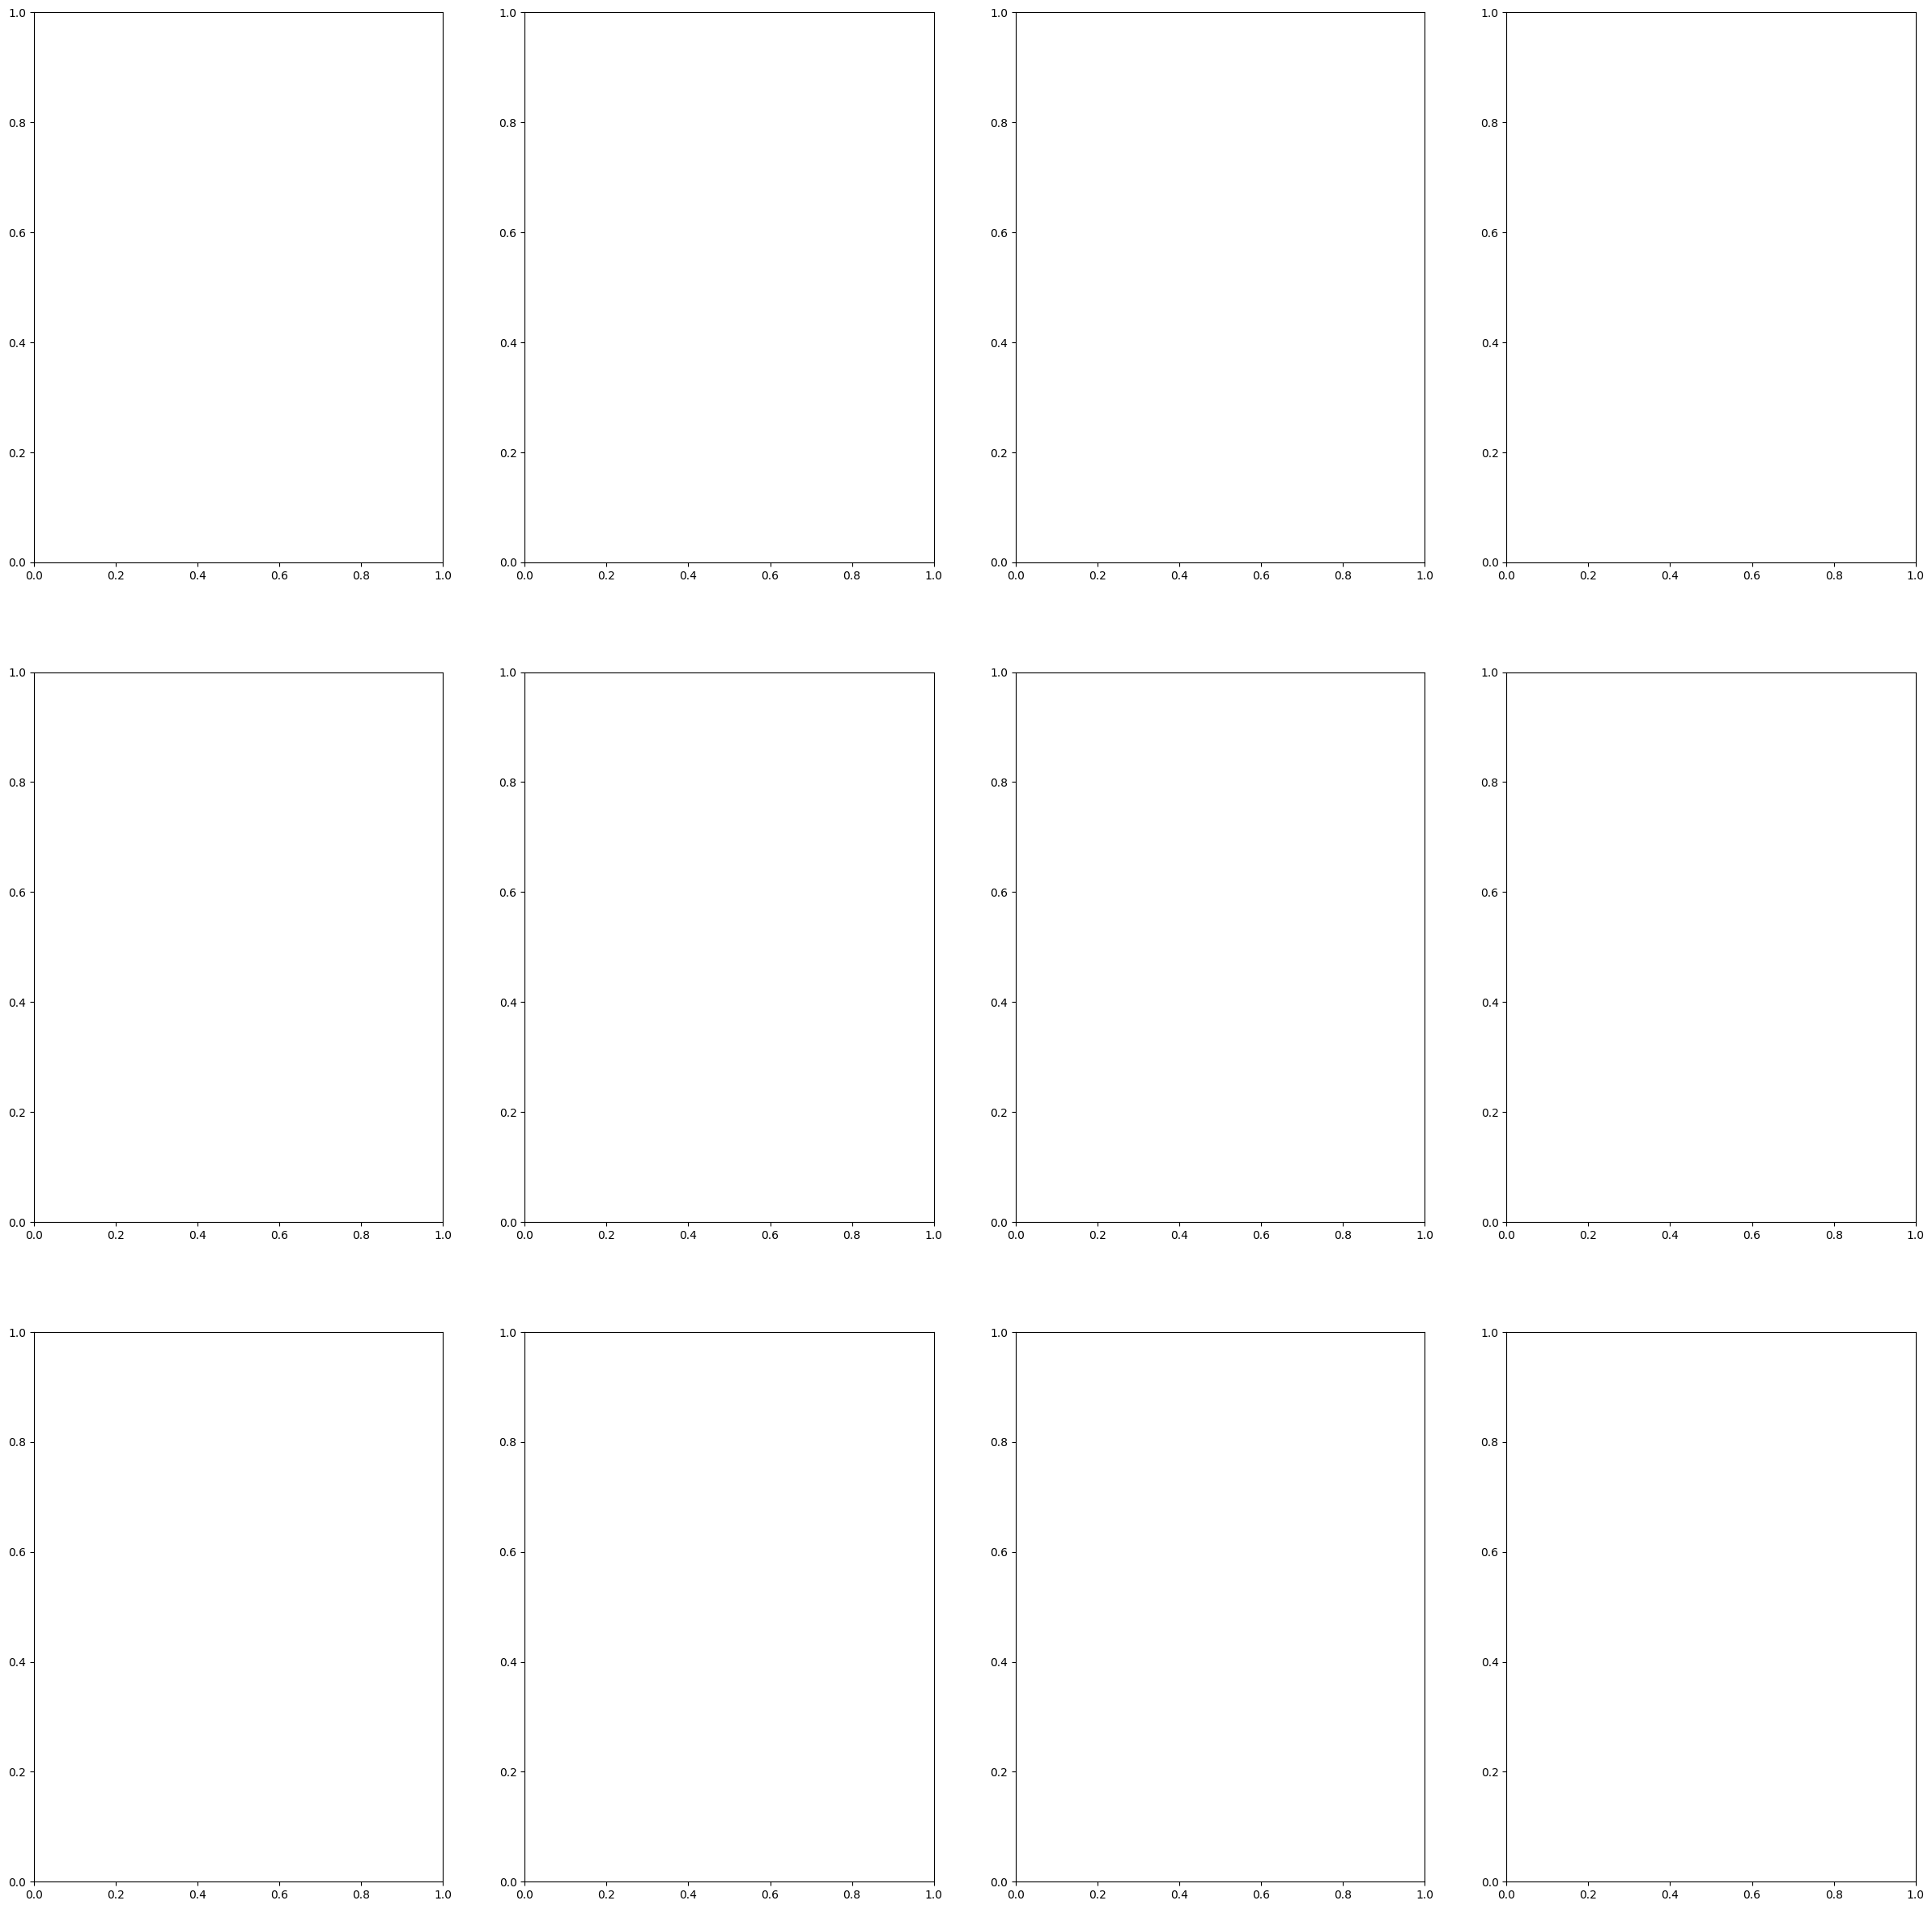

In [85]:
import seaborn as sns

import matplotlib.pyplot as plt

ax = ax.flatten()

token_value_by_dict_vec = []

for i in range(len(dictionary)):

    vals = sorted(dict_vec_target_improvements[i],reverse=True, key=lambda x: x[1])

    tokens = {}

    for idx, val in vals:
        tokens[one_gram_samples[idx]] = tokens.get(one_gram_samples[idx],0) + val

    token_value_by_dict_vec.append(tokens)

In [ ]:
fig, ax = plt.subplots(3,4,figsize=(30, 30))    

sns.barplot(x=list(tokens.values()),y=list(tokens.keys()),ax=ax[i])
ax[i].set_title(f"Dictionary Vector {i}")
ax[i].set_ylabel("Token")
ax[i].set_xlabel("Additive Improvement")

In [ ]:
# Total Additive Improvement
# Degree of High Improvement (Normalized) for Specific Tokens; Entropy